# Setup

In [1]:
# packages
import pandas as pd
from fuzzywuzzy import fuzz, process
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
nltk.data.find('tokenizers/punkt')

# data
df = pd.read_csv('merged_df_final.csv')
df = df.rename(columns={'Description sufficient': 'Description_sufficient'})
df = df.rename(columns={'Reason if insufficient': 'Reason_if_insufficient'})
df['Description_sufficient'] = df['Description_sufficient'].map({'yes': 1,'Yes':1, 'no':0})

/root/venv/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
#view dataset
df

,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description_sufficient,Reason_if_insufficient
0,a949379f-5ad7-4142-9681-004203a26fab,Keep,Corporate Functions,ConnectedMINDS Sprint – Working with Focus,The working environment has become more and mo...,0.0,other
1,b74aee44-454b-4eb3-9fec-0064eef530d9,Keep,Corporate Functions,Mental wellbeing in critical times: from confl...,"""Transformations are challenging. They also of...",NaN,NaN
2,70ca382a-aeb3-49b8-8465-009a4bb7932e,Keep,NBS,TPRM Training Sessions for Business Owners-Europe,"""We would like to invite you to familiarize yo...",NaN,NaN
3,e2ac5015-7116-4f5f-a486-00fa5c5d90b1,Keep,Global Drug Development,Critical Thinking Peer Learning Session,The aim of this session will be to discuss wit...,1.0,NaN
4,e055ddf9-4c8c-49c0-a96a-012100c43d16,Keep,NIBR,Beyond Awareness: Anti-racism in Action,Part 1 (15 Oct 2021: 10-11am ET) Interview wit...,NaN,NaN
...,...,...,...,...,...,...,...
7609,766c5446-979a-4575-9496-9c5f5390ae92,Keep,NBS,Introduction to LDC Deployment Methodology - ILT,Introduction to LDC Deployment Methodology - F...,NaN,NaN
7610,f2c6ff41-0cf1-44be-a9f5-9c5bf5f6e27b,Keep,Corporate Functions,Rewards & Recognition and Evolve,Join us for this webinar to build your underst...,NaN,NaN
7611,5bee5053-69e0-4bba-ab5e-9c77666f0053,Keep,NBS,Team Effectiveness Awareness Session for P&O/TODI,"In attending this session, you will familiariz...",NaN,NaN
7612,8ae7f112-0aa1-4d79-a872-9c8d3b10a076,Keep,Novartis Learning Institute,Communicate to Connect,The Communicate to Connect program enables an ...,NaN,NaN


In [3]:
sufficient_example = df[df['Description_sufficient']==1]

In [4]:
sufficient_example.to_csv('sufficient_example.csv')

# Feature Engineering

In [5]:
def is_complete(text):
    sentences = sent_tokenize(text)
    last_sentence = sentences[-1]
    return last_sentence.endswith('.')

In [6]:
# get description length
df['Number of words in Description'] = df["NVS_Course_Description_x"].apply(lambda n: len(n.split()))

In [7]:
df['NVS_Course_Description_length'] = df['NVS_Course_Description_x'].apply(lambda x: len(str(x)))

In [8]:
import numpy as np
# Calculate the mean and median of the description length
column_to_calculate = 'NVS_Course_Description_length'
mean = np.mean(df[column_to_calculate])
median = np.median(df[column_to_calculate])
print(mean)
print(median)

310.03296558970317
200.0


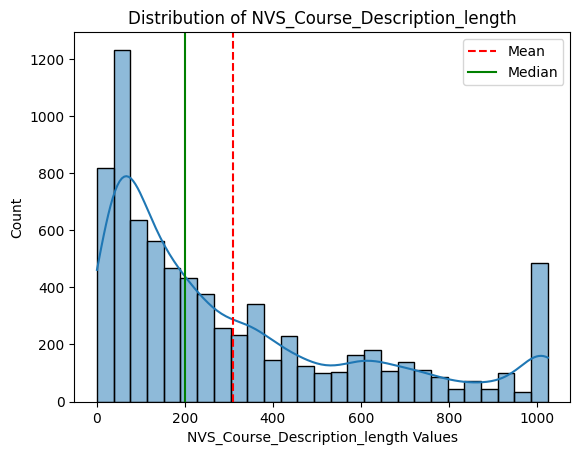

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot distribution of values of NVS_Course_Description_length
sns.histplot(data=df, x='NVS_Course_Description_length', kde=True)
plt.axvline(df['NVS_Course_Description_length'].mean(), color='r', linestyle='--', label='Mean')
plt.axvline(df['NVS_Course_Description_length'].median(), color='g', linestyle='-', label='Median')
plt.title('Distribution of NVS_Course_Description_length')
plt.xlabel('NVS_Course_Description_length Values')
plt.ylabel('Count')
plt.legend()
plt.show()

In [10]:
# fuzzy based similarity, create new feature 
df['similarity'] = df.apply(lambda row: fuzz.token_sort_ratio(row['NVS_Course_Training_Title_x'], row['NVS_Course_Description_x']), axis=1)

In [11]:
# Apply the is_complete function to create a new feature that examines if the description has completed sentences
df['is_complete'] = df['NVS_Course_Description_x'].apply(is_complete)
# convert to integer
df['is_complete'] = df['is_complete'].astype(int)

In [12]:
#first make a training dataset that will only include the labeled observations 
#and will be used for training tnad testing the model
Trainingset = df[df['Description_sufficient'].notna()]

In [13]:
#view training dataset
Trainingset

,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description_sufficient,Reason_if_insufficient,Number of words in Description,NVS_Course_Description_length,similarity,is_complete
0,a949379f-5ad7-4142-9681-004203a26fab,Keep,Corporate Functions,ConnectedMINDS Sprint – Working with Focus,The working environment has become more and mo...,0.0,other,170,1005,0,0
3,e2ac5015-7116-4f5f-a486-00fa5c5d90b1,Keep,Global Drug Development,Critical Thinking Peer Learning Session,The aim of this session will be to discuss wit...,1.0,NaN,58,375,0,0
5,520ba579-3762-4af4-8319-014a35a436e0,Keep,NBS,SAP Ariba Sourcing User Training,"""In this virtual training Procurement team mem...",1.0,NaN,70,485,0,0
9,a816c41e-4a5b-425f-b334-01c6c86ff2b2,Keep,SANDOZ,SDZ BCD_High Impact Meeting Facilitation,High Impact Meeting Facilitation Training for ...,0.0,missing relevance,7,52,67,0
11,70c34fce-05be-4ad8-8f36-0027e236db1a,Keep,NBS,SubWay Regulatory Core Labeling Author Course,Describes how to perform tasks and responsibil...,1.0,NaN,47,289,1,0
...,...,...,...,...,...,...,...,...,...,...,...
7535,f6ff4a18-b384-46a9-8c9c-9926910e3dd4,Keep,Novartis Learning Institute,New Employee Orientation (NEO),New Employee Orientation program is designed t...,1.0,NaN,49,422,0,0
7539,81c43a37-95ba-4a61-aa43-758f468964a5,Keep,Global Drug Development,NOVOPEX- OPEX Capability Program,NOVOPEX is an India OPEX Capability Build Prog...,1.0,NaN,146,1024,1,0
7543,66715ce8-4380-46c9-9955-75d7e2b22012,Keep,NBS,TPRM Training for Business Owners-Mandarin Ses...,We would like to invite you to familiarize you...,1.0,NaN,100,586,0,0
7575,7962ca50-6e02-4396-b411-636ecbd8b920,Keep,SANDOZ,2022_SSM PD_GCP_LLN,GCP-related lessons learned relevant to Sandoz...,0.0,missing relevance and context,10,82,14,0


In [14]:
#making the Description_sufficient an integer for the model
Trainingset['Description_sufficient'] = Trainingset['Description_sufficient'].astype(int)

/tmp/ipykernel_741/2284278168.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Trainingset['Description_sufficient'] = Trainingset['Description_sufficient'].astype(int)


# Model Training and Evaluation 

In [15]:
X = Trainingset.iloc[:,8:] #Explanatory variables, i don't include number of word in description, since it will provide similar information with the description length 
y = Trainingset['Description_sufficient'] #Outcome variable

In [16]:
#Split the training dataset to train and test, use 70% percent of the observations to train the model
#and reserve the rest 30% to test the model's performance
from sklearn.model_selection import train_test_split 
X, X_test, y, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [17]:
#Load packages that will be needed to run the model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
# Random Oversampling
oversampler = RandomOverSampler()
X_train, y_train = oversampler.fit_resample(X, y)

# Compute class weights because we still have some class imbalance
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

# Train the logistic regression model with class weighting
clf = LogisticRegression(class_weight={0: class_weights[0], 1: class_weights[1]})
clf.fit(X, y)

# Make predictions and evaluate the model performance
y_pred = clf.predict(X_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
test_accuracy = clf.score(X_test, y_test)
print(test_accuracy)

print("Precision: ", precision)
print("Recall: ", recall)

0.7422512234910277
Precision:  0.5765124555160143
Recall:  0.8059701492537313


In [18]:
#Model results (will be further explained in the thesis report)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.71      0.79       412
           1       0.58      0.81      0.67       201

    accuracy                           0.74       613
   macro avg       0.73      0.76      0.73       613
weighted avg       0.78      0.74      0.75       613



In [19]:
#Create the test dataset that contains all observations that were not labeled
Testset = df[df['Description_sufficient'].isna()]

In [20]:
#view test dataset
Testset

,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description_sufficient,Reason_if_insufficient,Number of words in Description,NVS_Course_Description_length,similarity,is_complete
1,b74aee44-454b-4eb3-9fec-0064eef530d9,Keep,Corporate Functions,Mental wellbeing in critical times: from confl...,"""Transformations are challenging. They also of...",NaN,NaN,150,1017,1,0
2,70ca382a-aeb3-49b8-8465-009a4bb7932e,Keep,NBS,TPRM Training Sessions for Business Owners-Europe,"""We would like to invite you to familiarize yo...",NaN,NaN,106,597,0,0
4,e055ddf9-4c8c-49c0-a96a-012100c43d16,Keep,NIBR,Beyond Awareness: Anti-racism in Action,Part 1 (15 Oct 2021: 10-11am ET) Interview wit...,NaN,NaN,47,286,2,1
6,8ba9aa90-9223-4402-9338-686d3960ddfd,Keep,Global Drug Development,Self inspection observation –CAPA #2031130,Awareness for writing risk assessment in case ...,NaN,NaN,15,104,22,0
7,17f788dc-fcca-4fd1-9a6f-01906a321581,Keep,NIBR,ATI Seminar Series,External specialist are presenting their knowl...,NaN,NaN,23,149,19,1
...,...,...,...,...,...,...,...,...,...,...,...
7609,766c5446-979a-4575-9496-9c5f5390ae92,Keep,NBS,Introduction to LDC Deployment Methodology - ILT,Introduction to LDC Deployment Methodology - F...,NaN,NaN,9,65,84,0
7610,f2c6ff41-0cf1-44be-a9f5-9c5bf5f6e27b,Keep,Corporate Functions,Rewards & Recognition and Evolve,Join us for this webinar to build your underst...,NaN,NaN,77,450,4,1
7611,5bee5053-69e0-4bba-ab5e-9c77666f0053,Keep,NBS,Team Effectiveness Awareness Session for P&O/TODI,"In attending this session, you will familiariz...",NaN,NaN,66,423,0,0
7612,8ae7f112-0aa1-4d79-a872-9c8d3b10a076,Keep,Novartis Learning Institute,Communicate to Connect,The Communicate to Connect program enables an ...,NaN,NaN,158,1016,0,0


In [21]:
X2 = Testset.iloc[:,8:]#Explanatory variables

In [22]:
# Make predictions and evaluate the model performance
y_pred_testset = clf.predict(X2)

In [23]:
#unite the predictions with the column "Description_sufficient" of the original dataset, 
#based on the index of the test dataset
df.loc[Testset.index, 'Description_sufficient'] = y_pred_testset

In [24]:
#view original dataset that now has all the predicitions of the column "Description_sufficient"
df

,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description_sufficient,Reason_if_insufficient,Number of words in Description,NVS_Course_Description_length,similarity,is_complete
0,a949379f-5ad7-4142-9681-004203a26fab,Keep,Corporate Functions,ConnectedMINDS Sprint – Working with Focus,The working environment has become more and mo...,0.0,other,170,1005,0,0
1,b74aee44-454b-4eb3-9fec-0064eef530d9,Keep,Corporate Functions,Mental wellbeing in critical times: from confl...,"""Transformations are challenging. They also of...",1.0,NaN,150,1017,1,0
2,70ca382a-aeb3-49b8-8465-009a4bb7932e,Keep,NBS,TPRM Training Sessions for Business Owners-Europe,"""We would like to invite you to familiarize yo...",1.0,NaN,106,597,0,0
3,e2ac5015-7116-4f5f-a486-00fa5c5d90b1,Keep,Global Drug Development,Critical Thinking Peer Learning Session,The aim of this session will be to discuss wit...,1.0,NaN,58,375,0,0
4,e055ddf9-4c8c-49c0-a96a-012100c43d16,Keep,NIBR,Beyond Awareness: Anti-racism in Action,Part 1 (15 Oct 2021: 10-11am ET) Interview wit...,1.0,NaN,47,286,2,1
...,...,...,...,...,...,...,...,...,...,...,...
7609,766c5446-979a-4575-9496-9c5f5390ae92,Keep,NBS,Introduction to LDC Deployment Methodology - ILT,Introduction to LDC Deployment Methodology - F...,0.0,NaN,9,65,84,0
7610,f2c6ff41-0cf1-44be-a9f5-9c5bf5f6e27b,Keep,Corporate Functions,Rewards & Recognition and Evolve,Join us for this webinar to build your underst...,1.0,NaN,77,450,4,1
7611,5bee5053-69e0-4bba-ab5e-9c77666f0053,Keep,NBS,Team Effectiveness Awareness Session for P&O/TODI,"In attending this session, you will familiariz...",1.0,NaN,66,423,0,0
7612,8ae7f112-0aa1-4d79-a872-9c8d3b10a076,Keep,Novartis Learning Institute,Communicate to Connect,The Communicate to Connect program enables an ...,1.0,NaN,158,1016,0,0


In [27]:
#Make a dataset with all the poor quality metadata that we will use to predict the reason 
#behind insufficient metadata quality
df_reason = df[df['Description_sufficient'] == 0.0]

In [28]:
#same way as before, we build a training dataset to train the model that has labeled values 
#for the "Reason_if_insufficient" column 
df_reason_labeled = df_reason[df_reason['Reason_if_insufficient'].notna()]

In [29]:
#view training dataset
df_reason_labeled

,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description_sufficient,Reason_if_insufficient,Number of words in Description,NVS_Course_Description_length,similarity,is_complete
0,a949379f-5ad7-4142-9681-004203a26fab,Keep,Corporate Functions,ConnectedMINDS Sprint – Working with Focus,The working environment has become more and mo...,0.0,other,170,1005,0,0
9,a816c41e-4a5b-425f-b334-01c6c86ff2b2,Keep,SANDOZ,SDZ BCD_High Impact Meeting Facilitation,High Impact Meeting Facilitation Training for ...,0.0,missing relevance,7,52,67,0
12,d307a09a-7297-4b3c-93d5-004765472a54,Keep,Corporate Functions,1. Coaching with Presence- 5 Management Discip...,Welcome to the 5Ds E-Learning Academy. The Aca...,0.0,missing relevance,77,495,1,1
15,a33de4c7-15dc-4772-9ae9-0055faa1c7fc,Keep,PHARMA,Situational Analysis: Patient Journey,After completion of this course you will be ab...,0.0,missing context,38,227,8,0
16,203b1d8f-b250-43fe-acb3-005770d0918a,Keep,NBS,Adapting to Parenthood - Self-care,To be able to successfully juggle parenthood a...,0.0,missing relevance and context,29,193,26,1
...,...,...,...,...,...,...,...,...,...,...,...
7489,fbba726f-ff20-4be4-875d-f6141cb156d4,Keep,NBS,Join our virtual job sharing connecting exchange!,We are organizing regular informal connecting ...,0.0,missing relevance and context,31,217,23,1
7490,e559c69e-80e5-49b3-9d93-f6406742f00f,Keep,Global Drug Development,Data Science Essentials,"An introduction to Data Science, a walk throug...",0.0,missing context,20,110,35,1
7491,bf01fc3f-29d2-4026-b8e1-f639795fd845,Keep,SANDOZ,Discovery Training,"After the training, self awareness of represen...",0.0,missing context,26,176,17,0
7516,fc2fc2ae-d3ce-46c9-acfc-75f9733c49c3,Keep,Global Drug Development,CO NL - Explanatory Training on Site Selection,This Event includes sessions to explain into m...,0.0,missing relevance and context,18,121,35,1


In [30]:
df_reason_labeled['Reason_if_insufficient'].value_counts()

missing relevance and context    764
missing context                  348
missing relevance                172
other                            112
Other                              8
MISSING RELEVANCE                  1
Name: Reason_if_insufficient, dtype: int64

In [31]:
#map the column "Reason_if_insufficient"
df_reason_labeled['Reason_if_insufficient'] = df_reason_labeled['Reason_if_insufficient'].map({'missing relevance': 1,'MISSING RELEVANCE': 1, 'missing context':2, 'missing relevance and context':3,'other':4, 'Other':4})

/tmp/ipykernel_741/2610352301.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reason_labeled['Reason_if_insufficient'] = df_reason_labeled['Reason_if_insufficient'].map({'missing relevance': 1,'MISSING RELEVANCE': 1, 'missing context':2, 'missing relevance and context':3,'other':4, 'Other':4})


In [32]:
#check the mapping in the dataset 
df_reason_labeled

,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description_sufficient,Reason_if_insufficient,Number of words in Description,NVS_Course_Description_length,similarity,is_complete
0,a949379f-5ad7-4142-9681-004203a26fab,Keep,Corporate Functions,ConnectedMINDS Sprint – Working with Focus,The working environment has become more and mo...,0.0,4,170,1005,0,0
9,a816c41e-4a5b-425f-b334-01c6c86ff2b2,Keep,SANDOZ,SDZ BCD_High Impact Meeting Facilitation,High Impact Meeting Facilitation Training for ...,0.0,1,7,52,67,0
12,d307a09a-7297-4b3c-93d5-004765472a54,Keep,Corporate Functions,1. Coaching with Presence- 5 Management Discip...,Welcome to the 5Ds E-Learning Academy. The Aca...,0.0,1,77,495,1,1
15,a33de4c7-15dc-4772-9ae9-0055faa1c7fc,Keep,PHARMA,Situational Analysis: Patient Journey,After completion of this course you will be ab...,0.0,2,38,227,8,0
16,203b1d8f-b250-43fe-acb3-005770d0918a,Keep,NBS,Adapting to Parenthood - Self-care,To be able to successfully juggle parenthood a...,0.0,3,29,193,26,1
...,...,...,...,...,...,...,...,...,...,...,...
7489,fbba726f-ff20-4be4-875d-f6141cb156d4,Keep,NBS,Join our virtual job sharing connecting exchange!,We are organizing regular informal connecting ...,0.0,3,31,217,23,1
7490,e559c69e-80e5-49b3-9d93-f6406742f00f,Keep,Global Drug Development,Data Science Essentials,"An introduction to Data Science, a walk throug...",0.0,2,20,110,35,1
7491,bf01fc3f-29d2-4026-b8e1-f639795fd845,Keep,SANDOZ,Discovery Training,"After the training, self awareness of represen...",0.0,2,26,176,17,0
7516,fc2fc2ae-d3ce-46c9-acfc-75f9733c49c3,Keep,Global Drug Development,CO NL - Explanatory Training on Site Selection,This Event includes sessions to explain into m...,0.0,3,18,121,35,1


In [33]:
X_train_reason = df_reason_labeled.iloc[:,8:] #explanatory variables
y_train_reason = df_reason_labeled['Reason_if_insufficient']#outcome variable

In [34]:
#split the training dataset to train and test data, use 70% for the model training and 
#keep the rest 30% for the model evaluation on the test data
from sklearn.model_selection import train_test_split 
X, X_test, y, y_test = train_test_split(X_train_reason,y_train_reason,test_size=0.3, random_state=42)

In [35]:
#import model
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_reason, y_train_reason)

# Make predictions and evaluate the model performance
y_pred_reason= model.predict(X_test)

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [36]:
#model performance on test set, the model is weak in predicting the classes 1 and 4
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_reason))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        55
           2       0.45      0.45      0.45       101
           3       0.66      0.90      0.76       236
           4       0.00      0.00      0.00        30

    accuracy                           0.61       422
   macro avg       0.28      0.34      0.30       422
weighted avg       0.48      0.61      0.53       422

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` para

In [37]:
#Make test dataset that has unlabeled values in the "Reason_if_insufficient" column
df_reason_unlabeled = df_reason[df_reason['Reason_if_insufficient'].isna()]

In [38]:
#view test dataset
df_reason_unlabeled

,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description_sufficient,Reason_if_insufficient,Number of words in Description,NVS_Course_Description_length,similarity,is_complete
6,8ba9aa90-9223-4402-9338-686d3960ddfd,Keep,Global Drug Development,Self inspection observation –CAPA #2031130,Awareness for writing risk assessment in case ...,0.0,NaN,15,104,22,0
7,17f788dc-fcca-4fd1-9a6f-01906a321581,Keep,NIBR,ATI Seminar Series,External specialist are presenting their knowl...,0.0,NaN,23,149,19,1
10,f194cdb0-a7b7-427e-9f01-0036d3c64c99,Keep,Novartis,CLSD Laboratory Training List,CLSD Training list,0.0,NaN,3,18,77,0
18,0746b87a-9d99-4e56-8434-5effa37b6a45,Keep,NBS,Creating Launch Confidence - April Webcast 2,Creating Launch Confidence,0.0,NaN,3,26,76,0
19,0c3fe418-e07a-4211-a39f-5f09222887c0,Keep,NBS,Managing your emotions guide,This guide provides a number of scenarios on h...,0.0,NaN,13,73,54,1
...,...,...,...,...,...,...,...,...,...,...,...
7598,ffb68d29-0945-4c1f-ac1c-41d8703f688b,Keep,Corporate Functions,Organization Design,ODyssey Program Expert Track,0.0,NaN,4,28,30,0
7600,70324e87-acb6-4cd2-9955-41fb05843843,Keep,NBS,D&I Switzerland - Novartis Welcome Days,For new associates of the Basel and Rhine Vall...,0.0,NaN,10,54,18,0
7602,fc479fca-8810-4588-8956-f91c29a3c144,Keep,NBS,Safe handling of highly active substances,Safe handling of highly active substances and ...,0.0,NaN,17,114,53,0
7609,766c5446-979a-4575-9496-9c5f5390ae92,Keep,NBS,Introduction to LDC Deployment Methodology - ILT,Introduction to LDC Deployment Methodology - F...,0.0,NaN,9,65,84,0


In [39]:
X_test_reason = df_reason_unlabeled.iloc[:,8:] #explanatory variables

In [40]:
y_pred_reason_un= model.predict(X_test_reason) #make the prediction

In [41]:
#Unite the prediction with the "Reason_if_insufficient" column in the original dataset
df.loc[df_reason_unlabeled.index, 'Reason_if_insufficient'] = y_pred_reason_un

In [42]:
df

,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description_sufficient,Reason_if_insufficient,Number of words in Description,NVS_Course_Description_length,similarity,is_complete
0,a949379f-5ad7-4142-9681-004203a26fab,Keep,Corporate Functions,ConnectedMINDS Sprint – Working with Focus,The working environment has become more and mo...,0.0,other,170,1005,0,0
1,b74aee44-454b-4eb3-9fec-0064eef530d9,Keep,Corporate Functions,Mental wellbeing in critical times: from confl...,"""Transformations are challenging. They also of...",1.0,NaN,150,1017,1,0
2,70ca382a-aeb3-49b8-8465-009a4bb7932e,Keep,NBS,TPRM Training Sessions for Business Owners-Europe,"""We would like to invite you to familiarize yo...",1.0,NaN,106,597,0,0
3,e2ac5015-7116-4f5f-a486-00fa5c5d90b1,Keep,Global Drug Development,Critical Thinking Peer Learning Session,The aim of this session will be to discuss wit...,1.0,NaN,58,375,0,0
4,e055ddf9-4c8c-49c0-a96a-012100c43d16,Keep,NIBR,Beyond Awareness: Anti-racism in Action,Part 1 (15 Oct 2021: 10-11am ET) Interview wit...,1.0,NaN,47,286,2,1
...,...,...,...,...,...,...,...,...,...,...,...
7609,766c5446-979a-4575-9496-9c5f5390ae92,Keep,NBS,Introduction to LDC Deployment Methodology - ILT,Introduction to LDC Deployment Methodology - F...,0.0,3,9,65,84,0
7610,f2c6ff41-0cf1-44be-a9f5-9c5bf5f6e27b,Keep,Corporate Functions,Rewards & Recognition and Evolve,Join us for this webinar to build your underst...,1.0,NaN,77,450,4,1
7611,5bee5053-69e0-4bba-ab5e-9c77666f0053,Keep,NBS,Team Effectiveness Awareness Session for P&O/TODI,"In attending this session, you will familiariz...",1.0,NaN,66,423,0,0
7612,8ae7f112-0aa1-4d79-a872-9c8d3b10a076,Keep,Novartis Learning Institute,Communicate to Connect,The Communicate to Connect program enables an ...,1.0,NaN,158,1016,0,0


In [54]:
df['Reason_if_insufficient'].value_counts()

3.0    3845
2.0     351
1.0     173
4.0     120
Name: Reason_if_insufficient, dtype: int64

In [43]:
df['Reason_if_insufficient'].unique()

array(['other', nan, 3, 'missing relevance', 'missing context',
       'missing relevance and context', 'Other', 2, 'MISSING RELEVANCE'],
      dtype=object)

In [44]:
#take the variable as string to be able to map it next
df['Reason_if_insufficient'] = df['Reason_if_insufficient'].astype(str)

In [46]:
#Map the values in the column 
df['Reason_if_insufficient'] = df['Reason_if_insufficient'].map({'missing relevance': 1,'MISSING RELEVANCE': 1, 'missing context':2, 'missing relevance and context':3,'other':4, 'Other':4, '3':3, '2':2})

In [47]:
df

,NVS_Training_Object_ID,NVS_Training_Action,NVS_Course_Training_Provider,NVS_Course_Training_Title_x,NVS_Course_Description_x,Description_sufficient,Reason_if_insufficient,Number of words in Description,NVS_Course_Description_length,similarity,is_complete
0,a949379f-5ad7-4142-9681-004203a26fab,Keep,Corporate Functions,ConnectedMINDS Sprint – Working with Focus,The working environment has become more and mo...,0.0,4.0,170,1005,0,0
1,b74aee44-454b-4eb3-9fec-0064eef530d9,Keep,Corporate Functions,Mental wellbeing in critical times: from confl...,"""Transformations are challenging. They also of...",1.0,NaN,150,1017,1,0
2,70ca382a-aeb3-49b8-8465-009a4bb7932e,Keep,NBS,TPRM Training Sessions for Business Owners-Europe,"""We would like to invite you to familiarize yo...",1.0,NaN,106,597,0,0
3,e2ac5015-7116-4f5f-a486-00fa5c5d90b1,Keep,Global Drug Development,Critical Thinking Peer Learning Session,The aim of this session will be to discuss wit...,1.0,NaN,58,375,0,0
4,e055ddf9-4c8c-49c0-a96a-012100c43d16,Keep,NIBR,Beyond Awareness: Anti-racism in Action,Part 1 (15 Oct 2021: 10-11am ET) Interview wit...,1.0,NaN,47,286,2,1
...,...,...,...,...,...,...,...,...,...,...,...
7609,766c5446-979a-4575-9496-9c5f5390ae92,Keep,NBS,Introduction to LDC Deployment Methodology - ILT,Introduction to LDC Deployment Methodology - F...,0.0,3.0,9,65,84,0
7610,f2c6ff41-0cf1-44be-a9f5-9c5bf5f6e27b,Keep,Corporate Functions,Rewards & Recognition and Evolve,Join us for this webinar to build your underst...,1.0,NaN,77,450,4,1
7611,5bee5053-69e0-4bba-ab5e-9c77666f0053,Keep,NBS,Team Effectiveness Awareness Session for P&O/TODI,"In attending this session, you will familiariz...",1.0,NaN,66,423,0,0
7612,8ae7f112-0aa1-4d79-a872-9c8d3b10a076,Keep,Novartis Learning Institute,Communicate to Connect,The Communicate to Connect program enables an ...,1.0,NaN,158,1016,0,0


In [48]:
df['Description_sufficient'].value_counts(dropna=False)

0.0    4489
1.0    3125
Name: Description_sufficient, dtype: int64

In [49]:
#prepare the file tha will be shared with the company for the content owners to improve their content
new_file_for_improvements = df[df['Description_sufficient']==0.0]

In [50]:
new_file_for_improvements.to_csv('improvements_raw.csv',index=False)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=09374e14-43a4-4eee-b362-608228cad85e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>